# Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network

In this notebook we reproduce some results of the Super Resolution paper [1] in PyTorch.

[1] Ledig, C., Theis, L., Huszár, F., Caballero, J., Cunningham, A., Acosta, A., ... & Shi, W. (2017). Photo-realistic single image super-resolution using a generative adversarial network. In _Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4681-4690)_.

## Pre-processing: Loading datasets
In a first step we download all the required datasets.

In [0]:
import requests

url_91 = ("https://drive.google.com/uc?export=download&id=1eVfd2Snh5bCl0ulMsRE4ker_p-o1M_lm")
url_set5 = ("https://drive.google.com/uc?export=download&id=1Cr4puJ1UpkXrGpzdpqZLNhZiZ2vaimoi")
url_set14 = ("https://drive.google.com/uc?export=download&id=1PQus6Glc3VsfVIywG6MAMBBBZVyyF_gB")
url_BSD300 = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/BSD300.zip")
url_BSD500 = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/BSD500.zip")
url_SuperTexture = ("https://github.com/jorisquist/DLSuperResolutionProject/raw/master/SuperTexture.zip")


# Download data from Google drive and store as zip.
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, "wb") as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)


download_url(url_91, "./91.zip")
download_url(url_set5, "./set5.zip")
download_url(url_set14, "./set14.zip")
download_url(url_BSD300, "./BSD300.zip")
download_url(url_BSD500, "./BSD500.zip")
download_url(url_SuperTexture, "./SuperTexture.zip")

from zipfile import ZipFile

with ZipFile("91.zip", "r") as zipObj:
    zipObj.extractall("./train_data")

with ZipFile("set5.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("set14.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("BSD300.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("BSD500.zip", "r") as zipObj:
    zipObj.extractall("./test_data")

with ZipFile("SuperTexture.zip", "r") as zipObj:
    zipObj.extractall("./test_data")


## Pre-processing: Prepare trainingset
We load in the training set using our custom loader. This loader also up/downscales the images.

In [0]:
from skimage import io
from os import listdir
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL


class SuperResolutionDataset(Dataset):
    def __init__(self, root_dir, upscale_factor, use_gpu=False, testing=False):
        self.testing = testing 
        self.use_gpu = use_gpu
        self.root_dir = root_dir
        self.upscale_factor = upscale_factor
        self.images = [
            f
            for f in listdir(self.root_dir)
            if f.endswith(".bmp") or f.endswith(".jpg")
        ]
        self.data = list()
        for image_name in self.images:
            self.data = self.data + self.get_data_from_image(image_name)
            
        if use_gpu:
            for i in range(len(self.data)):
                self.data[i] = (self.data[i][0].cuda(), self.data[i][1].cuda())
                
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        return self.data[item]

    def get_data_from_image(self, image_name):
        image = io.imread(self.root_dir + "/" + image_name)

        h, w = len(image), len(image[0])
        cropped_h = h - (h % self.upscale_factor)
        cropped_w = w - (w % self.upscale_factor)

        target_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop([cropped_h, cropped_w]),
            transforms.ToTensor(),
        ])

        input_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.CenterCrop([cropped_h, cropped_w]),
            transforms.Resize(
                [
                    int(cropped_h // self.upscale_factor),
                    int(cropped_w // self.upscale_factor),
                ],
                PIL.Image.BICUBIC,
            ),
            transforms.ToTensor(),
        ])

        input_tensor = input_transform(image)
        target_tensor = target_transform(image)


        if self.testing:
          data = list()
          data.append((input_tensor, target_tensor))
          return data

        else:
          target_size = 17*self.upscale_factor # patch size
          target_stride = 17*self.upscale_factor # patch stride
          target_patches = target_tensor.unfold(1, target_size, target_stride).unfold(2, target_size, target_stride)

          input_patches = input_tensor.unfold(1, 17, 17).unfold(2, 17, 17)
          
          data = list()
          # target_image = patches[:, 0, 0, :, :]
          for i in range(input_patches.shape[1]):
            for j in range(input_patches.shape[2]):
              data.append((input_patches[:, i, j, :, :], target_patches[:, i, j, :, :]))

          return data

    def imshow(self, img):
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_input(self, idx):
        img, _ = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()

    def imshow_target(self, idx):
        _, img = self.__getitem__(idx)
        img = torchvision.utils.make_grid(img)
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


In [150]:
S = 3 # channel dim
W = 256 # width
H = 256 # height

x = torch.randn(S, W, H)

size = 17*3 # patch size
stride = 17*3 # patch stride
patches = x.unfold(1, size, stride).unfold(2, size, stride)
print(patches.shape)
print(patches[:, 0, 0, :, :].shape)
print(patches.shape[1], patches.shape[2])
# > torch.Size([10, 2, 4, 4, 64, 64, 64])

torch.Size([3, 5, 5, 51, 51])
torch.Size([3, 51, 51])
5 5


The goal of this Deep Learning network is to upscale the image resolution. Therefore for our training set we first downscale the input. In the example below you see the input image for different upscale factors (9 and 3 respectively) whereas the target image is the image we want to retrieve in the end.

Size of dataset is 91
torch.Size([3, 45, 80]) torch.Size([3, 135, 240])
Input image (Up-scale factor 3): 


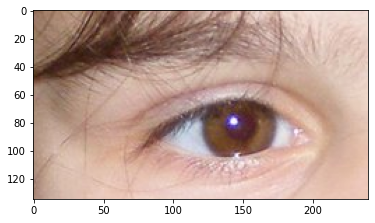

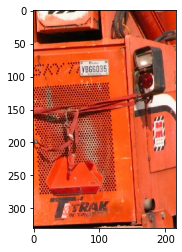

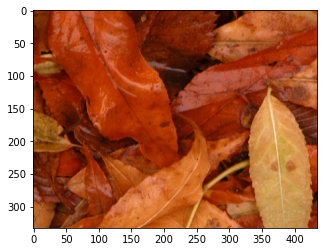

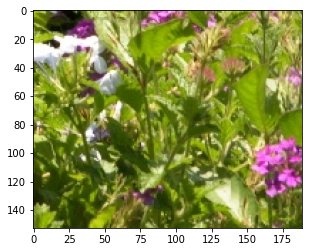

In [196]:
# trainExample9 = SuperResolutionDataset("train_data/Set91", 9)
# print("Input image (Up-scale factor 9): ")
# trainExample9.imshow_input(0)

trainExample3 = SuperResolutionDataset("train_data/Set91", 3, testing=True)
print("Input image (Up-scale factor 3): ")
for i in range(4):
  # trainExample3.imshow_input(i)
  trainExample3.imshow_target(i)

Target image: 


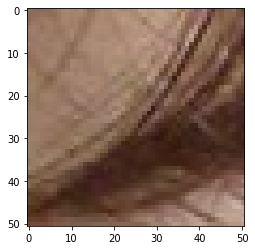

In [153]:
print("Target image: ")
trainExample3.imshow_target(0)

## Network Architecture

In [0]:
import torch.nn as nn
import torch

class SuperResolutionNet(nn.Module):
    def __init__(self, r, activation=nn.Identity()):
        super().__init__()
        self.r = r
        self.activation = activation

        self.deconvolution = nn.PixelShuffle(self.r)

        self.layers = nn.ModuleList([
            nn.Conv2d(3, 64, 5, padding=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.Conv2d(64, 32, 3, padding=1),
        ])

        self.last_layer = nn.Conv2d(32, self.r * self.r * 3, 3, padding=1)

        # self.params = list(self.layers.parameters())

        self.l = len(self.layers) - 1  # The number of hidden layers

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))

        x = self.last_layer(x)  # Don't use the activation on the last convolutional layer
        x = self.deconvolution(x)

        return x

## Training Network
Function to train a certain network with a certain data loader and hyperparameters

In [0]:
import os
import time
import math
import datetime

from torch import optim
from . import SuperResolutionNet

def mse_to_psnr(mse):
    return 10 * math.log10(1. / mse)

def train(net, use_gpu, train_loader, r,
          learning_rate=0.1,
          max_epochs_without_improvement=100,
          max_epochs=30000,
          print_output=True,
          beta1=0.9,
          beta2=0.999):

    # Decide to use GPU or not.
    if use_gpu:
        net = net.cuda()
        if print_output:
          print('Running on gpu')

    # Set loss function and optimizer.
    loss_function = nn.MSELoss()

    optimizer = optim.SGD(
    [
        {"params": net.layers.parameters()},
        {"params": net.last_layer.parameters(), "lr": learning_rate/10},
    ],
    lr=learning_rate,
    momentum=0.9
)

    print(len(optimizer.param_groups))
    for param in optimizer.param_groups:
      print(param['lr'])

    # Save computer name to use when storing network
    computer_name = "unknown"
    try:
      computer_name = os.environ['COMPUTERNAME']
    except:
      pass

    # Initialize loss.
    lowest_loss = (0, float('inf'))
    previous_loss = float('inf')
    highest_psnr = - float('inf')

    begin_time = time.time()
    minimum_psnr_to_save = 20

    # Start training.
    for epoch in range(max_epochs):
        train_loss = []

        # Train and propagate through network.
        net.train()
        for input, target in train_loader:

            optimizer.zero_grad()

            output = net(input)

            loss = loss_function(output, target)

            loss.backward()

            optimizer.step()

            train_loss.append(loss.item())

        mean_train_loss = np.mean(train_loss)
        mean_psnr = mse_to_psnr(mean_train_loss)

        if previous_loss - mean_train_loss < 0:
          old_learning_rate = optimizer.param_groups[0]['lr']
          optimizer.param_groups[0]['lr']
          new_learning_rate = max(0.0001, old_learning_rate - 0.0001)
          optimizer.param_groups[0]['lr'] = new_learning_rate

          # Learning rate of the last layer should be 10 times lower
          optimizer.param_groups[1]['lr'] = new_learning_rate/10


        previous_loss = mean_train_loss
          

        # Update the lowest loss if necessary.
        if mean_train_loss < lowest_loss[1]:
            #print(f"Epoch: {epoch: >3} Training Loss: {mean_train_loss:.6f} Mean PSNR: {mean_psnr:.2f} in {time.time() - begin_time:.2f}s #")
            lowest_loss = (epoch, mean_train_loss)
            highest_psnr = mean_psnr
          

            #If the psnr is above some threshold save this new best network.
            if highest_psnr > minimum_psnr_to_save:
                torch.save(net, f'SuperResulutionNet_best_of_run-{computer_name}')

        if epoch % 10 == 0 and print_output:
          
            print(
              f"Epoch: {epoch: >3} in {str(datetime.timedelta(seconds=int(time.time() - begin_time)))}, best epoch so far: Epoch: {lowest_loss[0]: >3} Training Loss: {lowest_loss[1]:.6f} Mean PSNR: {highest_psnr:.2f}, lr={ optimizer.param_groups[0]['lr']:.6f}")


        # If we didn't improve for some amount of epoch, lets stop.
        if epoch > lowest_loss[0] + max_epochs_without_improvement:
            if print_output:
                print(f"No improvement for the last {max_epochs_without_improvement} epochs, so stopping training...")
            break

    net.eval()
    if highest_psnr >= minimum_psnr_to_save:
        network_name = f'SuperResulutionNet_r-{r}_psnr-{int(round(highest_psnr * 100))}__mse-{int(round(lowest_loss[1] * 10000))}-{computer_name}'
        old_file = os.path.join(".", f'SuperResulutionNet_best_of_run-{computer_name}')
        new_file = os.path.join(".", network_name)
        if print_output:
            print(f'Saving best epoch ({lowest_loss[0]}) with loss: {lowest_loss[1]} and psnr: {highest_psnr} as:')
            print(network_name)
        os.rename(old_file, new_file)
    elif print_output:
        print("Not high enough psnr to save the network...")

    return lowest_loss[1]

In [96]:


# pixel_shuffle = nn.PixelShuffle(3)
# input = torch.randn(1, 9, 4, 4)
# output = pixel_shuffle(input)
# print(input.size())
# print(output.size())
# print(squeeze(output, 3).size())
# print(torch.equal(squeeze(output, 3), torch.randn(1, 9, 4, 4)))

torch.Size([1, 9, 4, 4])
torch.Size([1, 1, 12, 12])
torch.Size([1, 9, 4, 4])
False


In [234]:
use_gpu = torch.cuda.is_available()

# Batch size.
bs = 32

# Upscale factor.
r = 3

# Amount of epochs.
epochs = 20

# Getting image data
transform = transforms.Compose([transforms.ToTensor()])  # ,

# Load the training data.
training_set = SuperResolutionDataset("train_data/Set91", r, use_gpu=use_gpu)

train_loader = torch.utils.data.DataLoader(training_set, batch_size=bs, shuffle=True)

# Initialize the network.
net = SuperResolutionNet(r, activation=nn.ReLU())

train(net, use_gpu, train_loader, r)

Running on gpu
2
0.1
0.01
Epoch:   0 in 0:00:00, best epoch so far: Epoch:   0 Training Loss: 0.085951 Mean PSNR: 10.66, lr=0.100000


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type SuperResolutionNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch:  10 in 0:00:01, best epoch so far: Epoch:  10 Training Loss: 0.007180 Mean PSNR: 21.44, lr=0.100000
Epoch:  20 in 0:00:03, best epoch so far: Epoch:  20 Training Loss: 0.005375 Mean PSNR: 22.70, lr=0.099990
Epoch:  30 in 0:00:05, best epoch so far: Epoch:  30 Training Loss: 0.004607 Mean PSNR: 23.37, lr=0.099970
Epoch:  40 in 0:00:06, best epoch so far: Epoch:  40 Training Loss: 0.004147 Mean PSNR: 23.82, lr=0.099960
Epoch:  50 in 0:00:08, best epoch so far: Epoch:  50 Training Loss: 0.003808 Mean PSNR: 24.19, lr=0.099960
Epoch:  60 in 0:00:09, best epoch so far: Epoch:  60 Training Loss: 0.003542 Mean PSNR: 24.51, lr=0.099940
Epoch:  70 in 0:00:11, best epoch so far: Epoch:  69 Training Loss: 0.003364 Mean PSNR: 24.73, lr=0.099920
Epoch:  80 in 0:00:13, best epoch so far: Epoch:  80 Training Loss: 0.003225 Mean PSNR: 24.91, lr=0.099910
Epoch:  90 in 0:00:14, best epoch so far: Epoch:  90 Training Loss: 0.003082 Mean PSNR: 25.11, lr=0.099900
Epoch: 100 in 0:00:16, best epoch so 

0.0018966662610182539

## Evaluation

In [0]:
import math

import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms
from os import listdir

# from SuperResolutionDataset import SuperResolutionDataset
import numpy as np


def imshow(img):
    npimg = img.numpy()
    plt.figure()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def evaluate_by_name(network_name):
    net = torch.load(network_name)
    evaluate(net)
    
def evaluate(network):
    r = net.r
    print(f"r: {r}")

    use_gpu = torch.cuda.is_available()

    test_set_paths = ["test_data/" + f for f in listdir("test_data")]
#     test_set_paths = ["test_data/Custom"]

    for path in test_set_paths:
        psnr = []
        test_set = SuperResolutionDataset(path, r, use_gpu=use_gpu, testing=True)


        test_loader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=1,
                                                  shuffle=True,
                                                  num_workers=0)


        for input, target in iter(test_loader):
            if use_gpu:
                input = input.cuda()
                target = target.cuda()

            if input.size()[1] == 1:
                input = input.repeat(1, 3, 1, 1)

            output = net(input)


            if use_gpu:
                input = input.cpu()
                output = output.cpu()
                target = target.cpu()


            bicubic = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.BICUBIC),
                transforms.ToTensor()
            ])
            bicubic_upscaled = bicubic(input[0])

            nearest_neighbour = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize([int(r * input.size()[2]),
                                   int(r * input.size()[3])],
                                  PIL.Image.NEAREST),
                transforms.ToTensor()
            ])

            input = nearest_neighbour(input[0])
            output = torch.clamp(output.detach(), 0, 1)


            if target.size()[1] == 1:
                target = target.repeat(1, 3, 1, 1)

            mse_loss = nn.MSELoss()
            psnr.append(10 * math.log10(1. / mse_loss(output, target).item()))

            images = [input, target[0], output.detach()[0], bicubic_upscaled]

#             imshow(torchvision.utils.make_grid(images))

        print(f"{path} psnr: {np.mean(psnr)}")

    # plt.show()

In [236]:
evaluate(net)

r: 3
test_data/BSD500 psnr: 26.94326970778492
test_data/Set5 psnr: 30.326357748571127
test_data/BSD300 psnr: 27.044942701721467
test_data/Set14 psnr: 27.02293294300825
test_data/SuperTexture psnr: 24.89745817969632


In [0]:
evaluate_by_name('SuperResulutionNet_r-3_psnr-2931__mse-12-unknown')

r: 3
test_data/Set5 psnr: 30.56521187050867
test_data/Set14 psnr: 27.218189582749964


### Finding Hyperparameters
We use the AX framework to find the best hyperparameters for the network. 

In [0]:
!pip3 install ax-platform 

     |████████████████████████████████| 501kB 8.9MB/s 
     |████████████████████████████████| 225kB 18.6MB/s 
     |████████████████████████████████| 235kB 23.4MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.0.1-py2.py3-none-any.whl size=390441 sha256=93a85ac24a037851d0e2df693e98779cf5d971c5903d423d15ca192c0da322b4
  Stored in directory: /root/.cache/pip/wheels/10/2f/7a/3328e5713d796daeec2ce8ded141d5f3837253fc3c2a5c62e0
Successfully built gpytorch


In [0]:
from ax import optimize

def train_evaluate(parameters):
    use_gpu = torch.cuda.is_available()
    bs = 32
    r = 3

    training_set = SuperResolutionDataset('train_data/Set91', r, use_gpu=use_gpu)
    # training_set = SuperResolutionDataset('test_data/BSD500', r, use_gpu=use_gpu)

    train_loader = torch.utils.data.DataLoader(
        training_set, batch_size=bs, shuffle=True, num_workers=0
    )

    # Initialize the network.
    net = SuperResolutionNet(r, activation=nn.ReLU())

    return train(net, use_gpu, train_loader, r,
                 max_epochs=500,
                 max_epochs_without_improvement=100, 
                 learning_rate=parameters['lr'],
                 beta1=parameters['beta1'],
                 beta2=parameters['beta2'],
                 print_output=False)


best_parameters, best_values, experiment, model = optimize(
        parameters=[
            {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
            {"name": "beta1", "type": "range", "bounds": [0.5, 0.9]},
            {"name": "beta2", "type": "range", "bounds": [0.9, 0.999]},
        ],
        # Booth function
        evaluation_function=train_evaluate,
        objective_name='training-error',
        minimize=True,
    )

print(best_parameters, best_values, experiment, model)

[INFO 04-15 18:57:18] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 04-15 18:57:18] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 04-15 18:57:18] ax.service.managed_loop: Running optimization trial 1...
[INFO 04-15 18:59:53] ax.service.managed_loop: Running optimization trial 2...
[INFO 04-15 19:02:25] ax.service.managed_loop: Running optimization trial 3...
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type SuperResolutionNet. It won't be checked for correctness upon loading.

[INFO 04-15 19:04:59] ax.service.managed_loop: Running optimization trial 4...
[INFO 04-15 19:07:32] ax.service.managed_loop: Running optimization trial 5...
[INFO 04-15 19:10:04] a

{'lr': 0.00021549701027822157, 'beta1': 0.9, 'beta2': 0.950832449581164} ({'training-error': 0.0023424733267122626}, {'training-error': {'training-error': 1.949802386971656e-10}}) SimpleExperiment(None) <ax.modelbridge.torch.TorchModelBridge object at 0x7fb37acbf0b8>


In [0]:
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.contour import plot_contour

render(plot_contour(model=model, param_x='lr', param_y='beta1', metric_name='training-error'))
render(plot_contour(model=model, param_x='beta1', param_y='beta2', metric_name='training-error'))
render(plot_contour(model=model, param_x='lr', param_y='beta2', metric_name='training-error'))

Use the best parameters found by the bayesion optimization to train a network.

In [0]:
net = SuperResolutionNet(r, activation=nn.ReLU())
train(net, use_gpu, train_loader, r,
                 max_epochs=1000,
                 max_epochs_without_improvement=100, 
                 learning_rate=best_parameters['lr'],
                 beta1=best_parameters['beta1'],
                 beta2=best_parameters['beta2'],
                 )
evaluate(net)

Running on gpu
Epoch:   0 in 0.39s, best epoch so far: Epoch:   0 Training Loss: 0.088246 Mean PSNR: 10.54


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning:

Couldn't retrieve source code for container of type SuperResolutionNet. It won't be checked for correctness upon loading.



Epoch: 100 in 32.96s, best epoch so far: Epoch: 100 Training Loss: 0.002135 Mean PSNR: 26.71
Epoch: 200 in 65.27s, best epoch so far: Epoch: 185 Training Loss: 0.001792 Mean PSNR: 27.47
Epoch: 300 in 97.24s, best epoch so far: Epoch: 288 Training Loss: 0.001633 Mean PSNR: 27.87
Epoch: 400 in 129.17s, best epoch so far: Epoch: 394 Training Loss: 0.001551 Mean PSNR: 28.10
Epoch: 500 in 160.99s, best epoch so far: Epoch: 481 Training Loss: 0.001466 Mean PSNR: 28.34
Epoch: 600 in 193.08s, best epoch so far: Epoch: 598 Training Loss: 0.001384 Mean PSNR: 28.59
Epoch: 700 in 224.81s, best epoch so far: Epoch: 690 Training Loss: 0.001367 Mean PSNR: 28.64
Epoch: 800 in 256.64s, best epoch so far: Epoch: 777 Training Loss: 0.001326 Mean PSNR: 28.77
Epoch: 900 in 288.72s, best epoch so far: Epoch: 889 Training Loss: 0.001308 Mean PSNR: 28.84
Saving best epoch (994) with loss: 0.0012854222453745972 and psnr: 28.9095418850852 as:
SuperResulutionNet_r-3_psnr-2891__mse-13-unknown
r: 3
test_data/Set5 